In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from pathlib import Path

import shamans.utils.eval_utils as eval

In [ ]:
ang_error_threshold_choices = [15]

In [2]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False, encoding='utf-8-sig')
    return combined_csv

In [3]:
# load data
exp_id = 3
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)

In [ ]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees
def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)

# compute accuracy and recall based on the frame id as in DCASE Task 3
unique_frame_ids = exp_df['frame_id'].unique()
unique_method_ids = exp_df['method_id'].unique()

df_thresholds = pd.DataFrame()

for frame_id in tqdm(unique_frame_ids, desc='frame'):
    df_frame = exp_df[exp_df['frame_id'] == frame_id]
    
    for method_id in unique_method_ids:
        df_method = df_frame[df_frame['method_id'] == method_id]    
                
        assert len(df_method) == np.unique(df_method['doas_est_az']).shape[0] == np.unique(df_method['n_sources'])
            
        # accuracy and mean error
        for thr in ang_error_threshold_choices:
            
            accuracy = np.sum(df_method['ang_error'] <= thr) / len(df_method)
            error = np.mean(df_method[df_method['ang_error'] <= thr]['ang_error'])

            df_ = pd.DataFrame({
                "frame_id": frame_id,
                "method_id": method_id,
                "accuracy": accuracy,
                "mean_error": error,
                "threshold": thr
            }, index=[0])
            df_thresholds = pd.concat([df_thresholds, df_], ignore_index=True)

frame: 100%|██████████| 168/168 [00:07<00:00, 21.44it/s]


In [5]:
df_merge = exp_df.merge(df_thresholds, on=['frame_id', 'method_id'])

In [6]:
# n_sources_choice = [1]
# source_type_choices = ['speech']
# snr_choices = np.arange(-30, 31, 10).tolist()
# noise_type_choices = ['awgn', 'alpha-1.2', 'alpha-0.8']
# sound_duration_choices = [0.5]
# add_reverb_choices = [False]

df_merge = df_merge.assign(sv_model=df_merge['sv_method'] + '_' + df_merge['nObs'].astype(str))
df_merge = df_merge.assign(loc_algo=df_merge['loc_method'].str[:3])

print(df_merge['sv_method'].unique())
print(df_merge['sv_model'].unique())
print(df_merge['noise_type'].unique())
print(df_merge['n_sources'].unique())
print(df_merge['snr'].unique())
print(df_merge['duration'].unique())
print(df_merge['rt60'].unique())
print(df_merge['loc_method'].unique())

['ref' 'alg' 'gp-steerer']
['ref_8' 'alg_8' 'gp-steerer_8' 'gp-steerer_16' 'gp-steerer_32'
 'gp-steerer_64' 'gp-steerer_128']
['awgn']
[1 2 3 4 5 6 7]
[20]
[1.]
[0.    0.123 0.273]
['alpha-1.2_beta-1_eps-1E-3_iter-500' 'music_s-1' 'music_s-4' 'music_s-2'
 'alpha-2.0_beta-2_eps-1E-3_iter-500' 'music_s-3'
 'alpha-1.2_beta-2_eps-1E-3_iter-500' 'srp_phat'
 'alpha-1.2_beta-0_eps-1E-3_iter-500']


In [7]:
best_seed = 666
# rename ref_8 and alg_6 to ref and alg
df_merge['sv_model'] = df_merge['sv_model'].str.replace('ref_8', 'ref')
df_merge['sv_model'] = df_merge['sv_model'].str.replace('alg_8', 'alg')
df_merge.loc[df_merge['sv_model'] == 'ref', 'seed'] = 666
df_merge.loc[df_merge['sv_model'] == 'alg', 'seed'] = 666

In [8]:
n_max_sources = np.max(df_merge['n_sources'])
loc_methods = np.unique(df_merge['loc_method'])
sv_methods = np.unique(df_merge['sv_method'])
rt60_choices = np.unique(df_merge['rt60'])
thresholds = np.unique(df_merge['threshold'])

print(thresholds)

[15]


['alpha' 'music_s' 'srp_phat']
rt60: 0.0


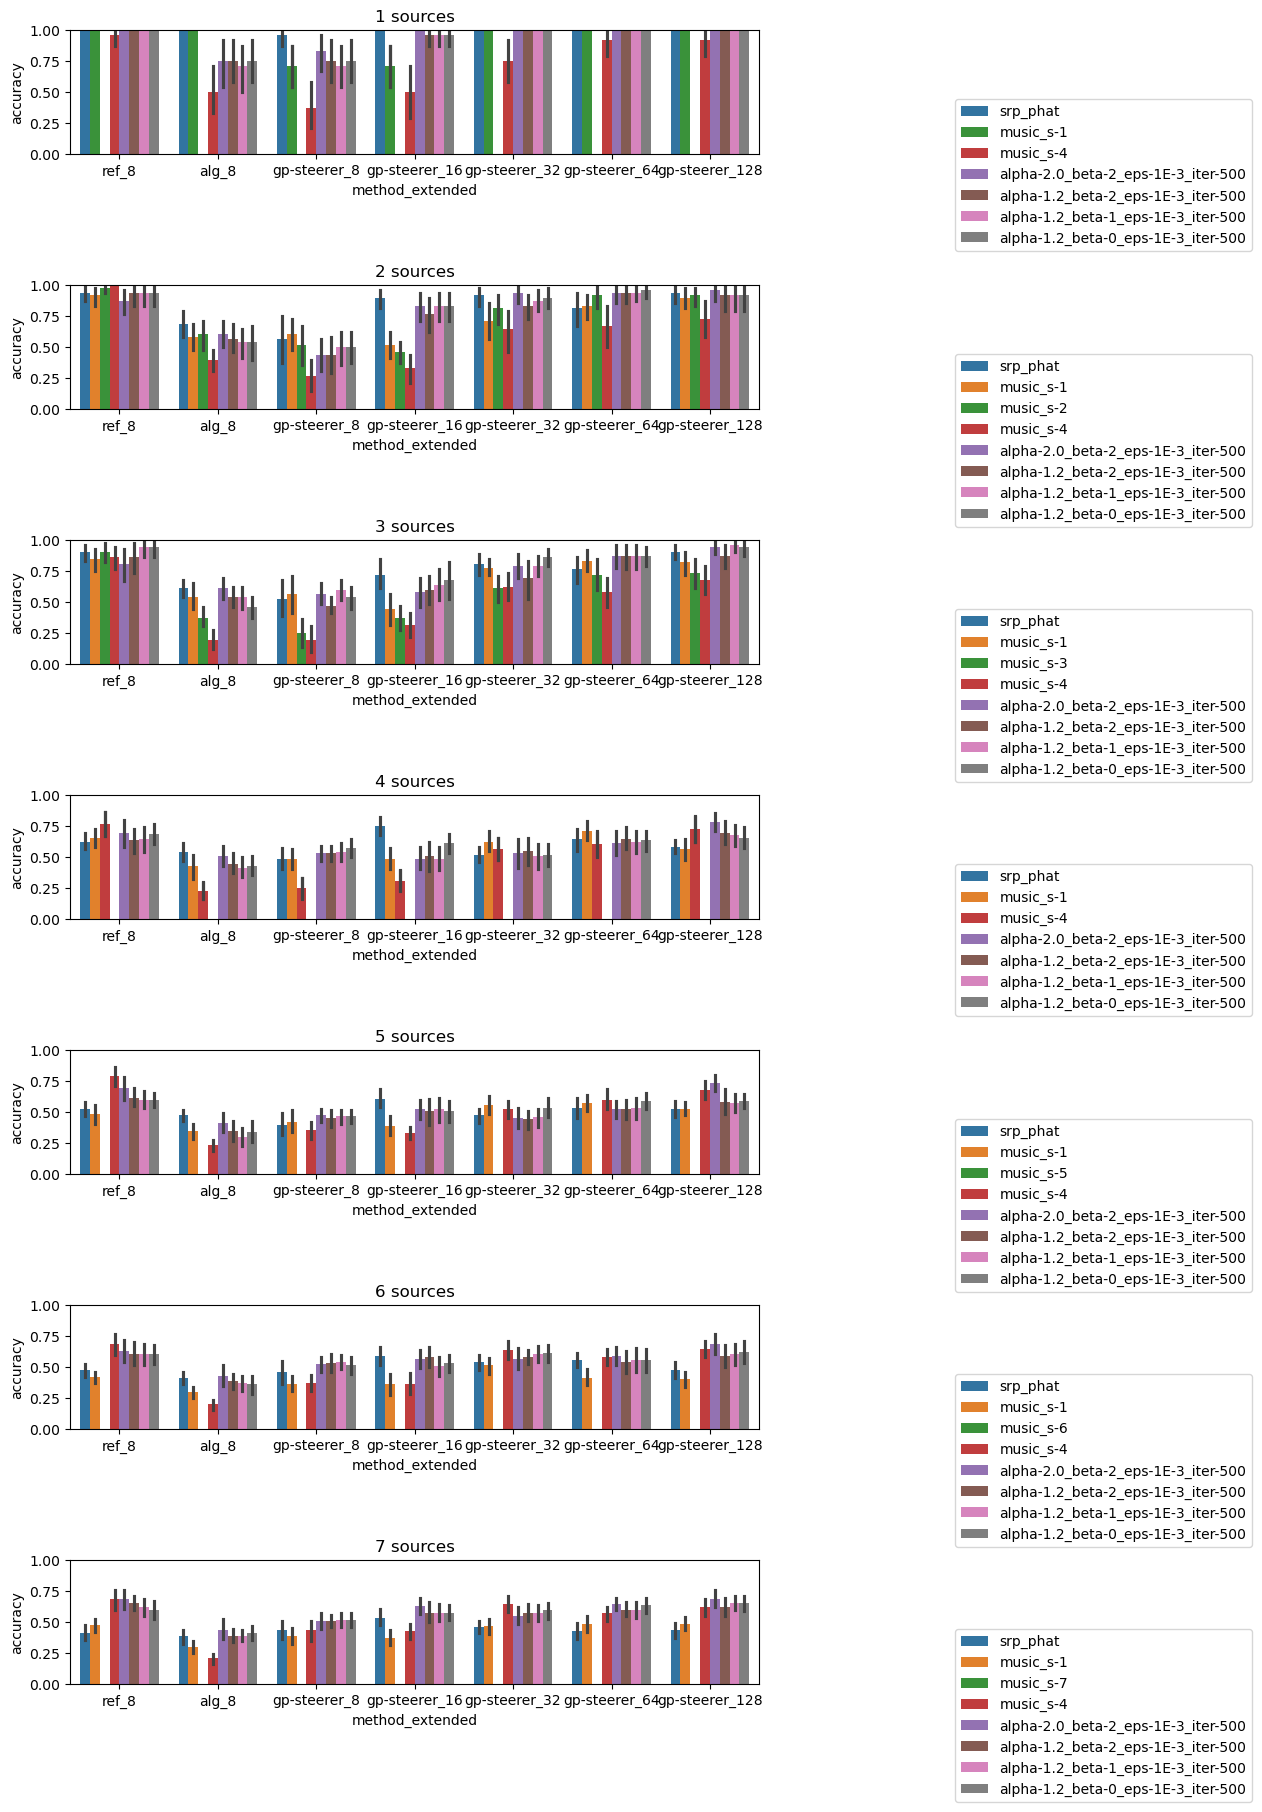

rt60: 0.123


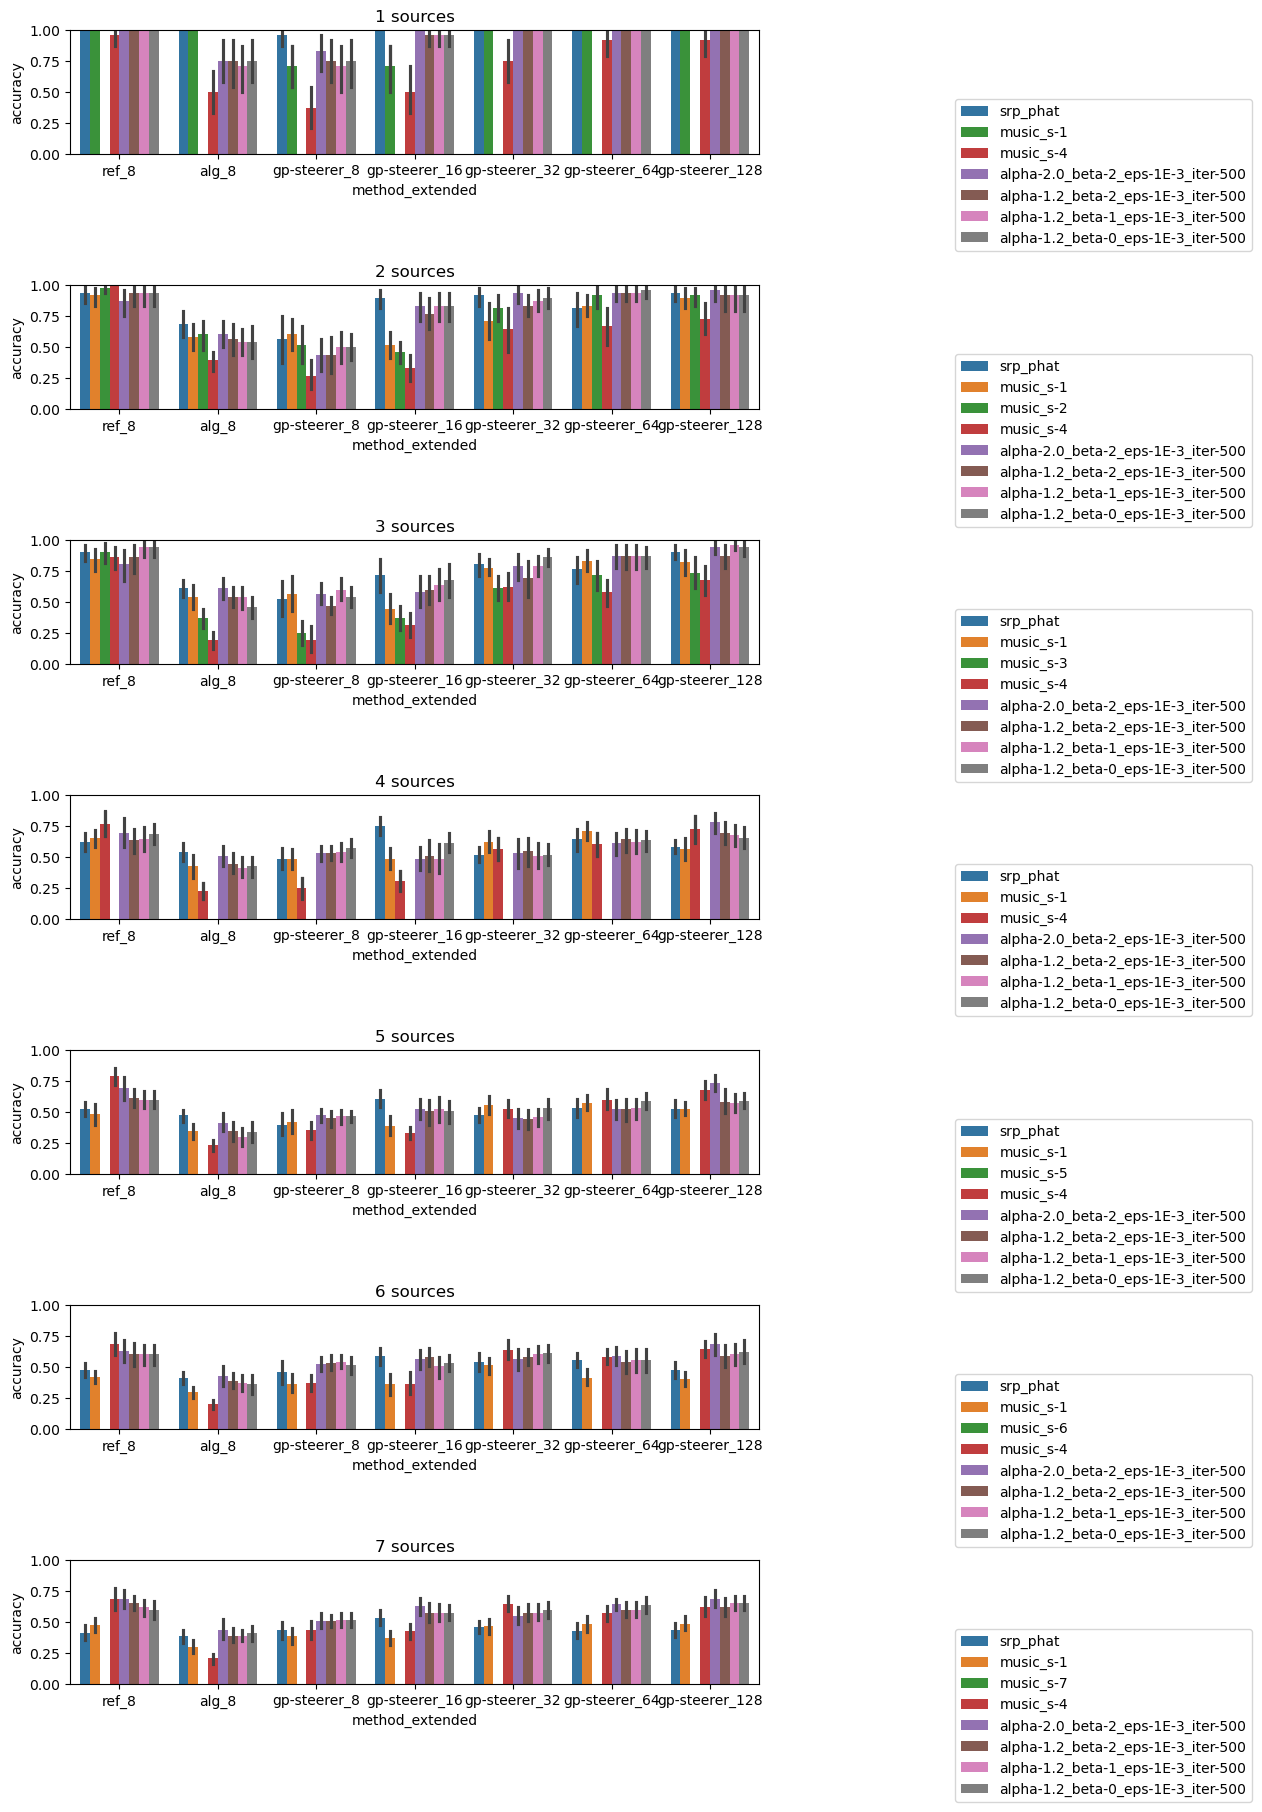

rt60: 0.273


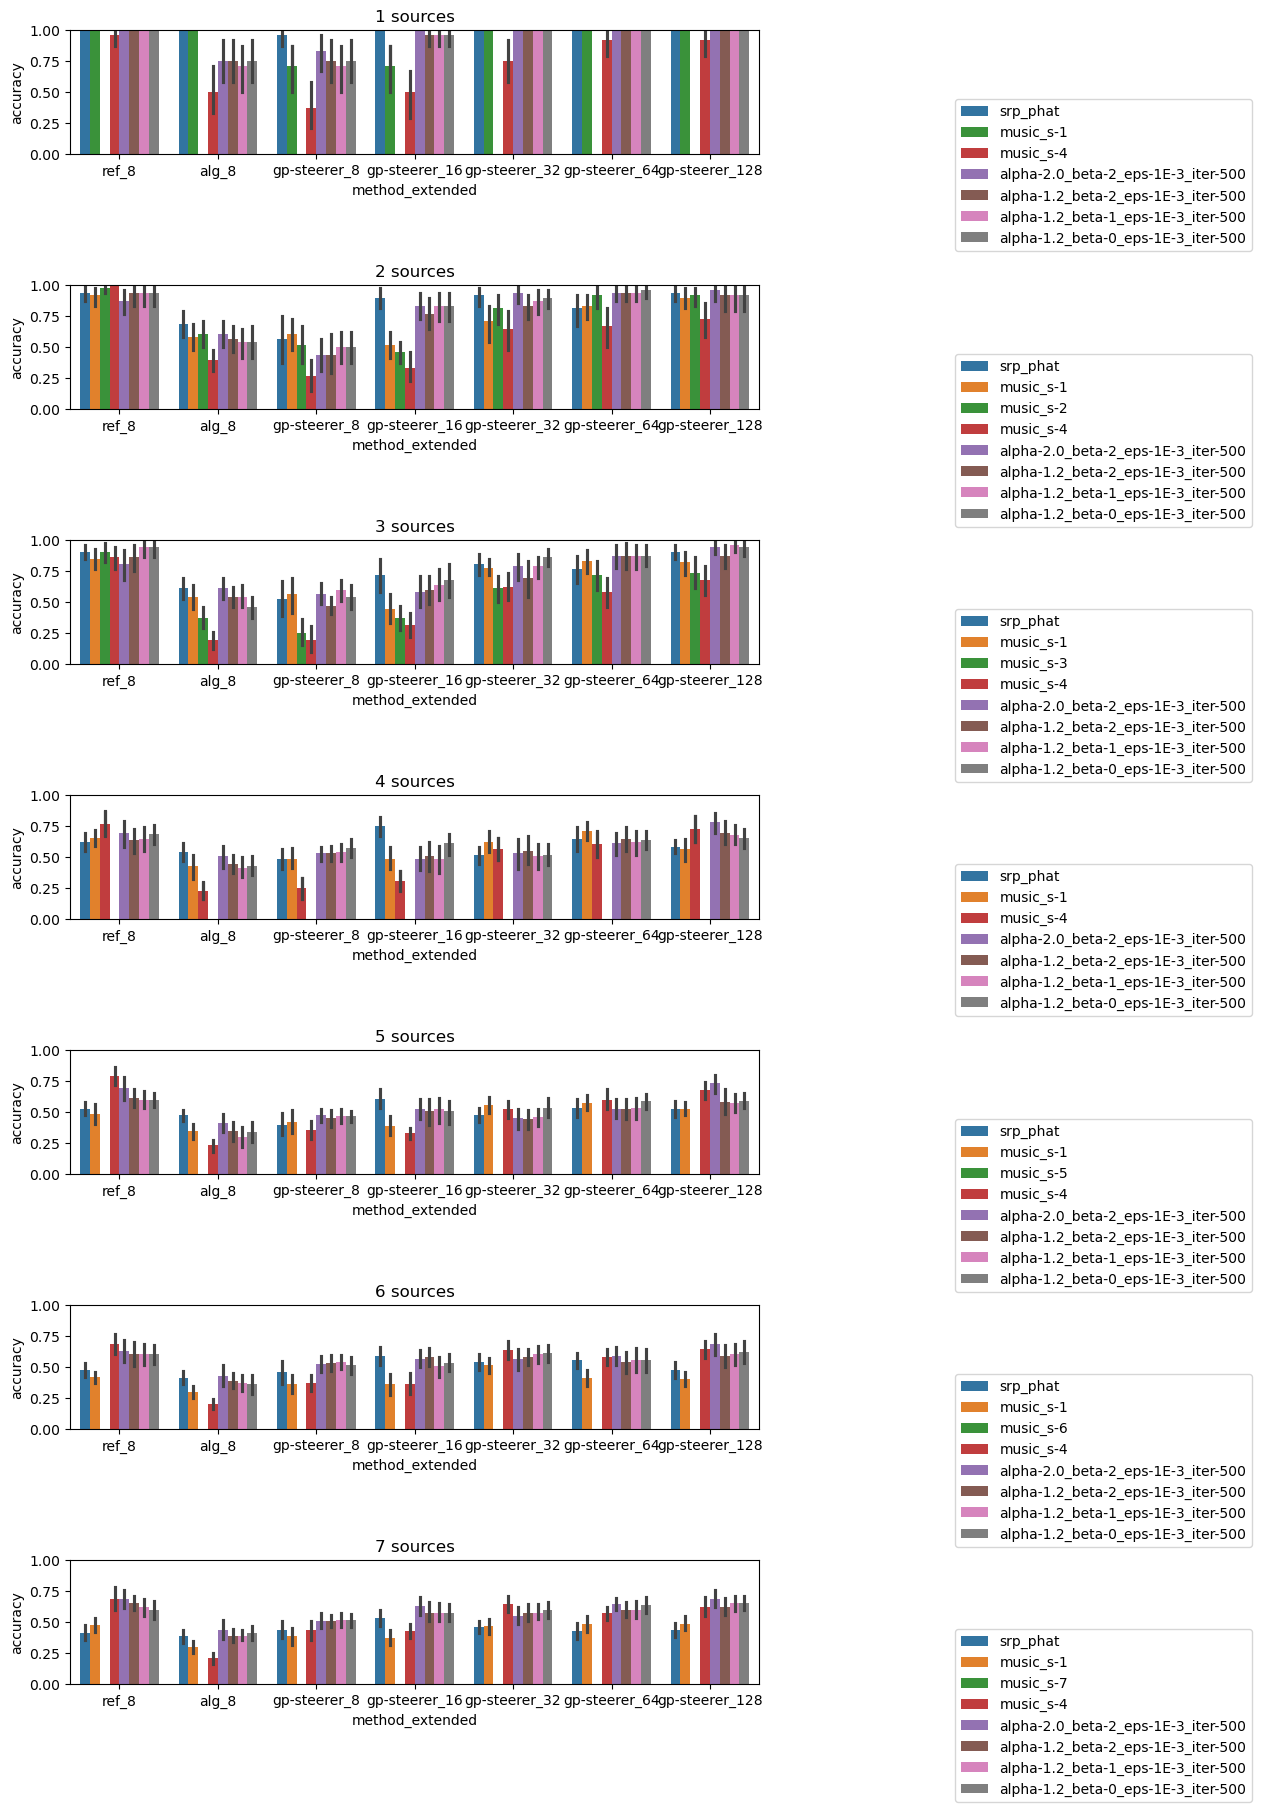

In [9]:
df_merge['loc_method_simple'] = df_merge['loc_method'].apply(lambda x: x.split('-')[0])

print(df_merge['loc_method_simple'].unique())


for rt60 in rt60_choices:
    print(f'rt60: {rt60}')
    
    fig, axarr = plt.subplots(n_max_sources, 1, figsize=(15, 18))
    for i, n_sources in enumerate(range(n_max_sources)):
        algos = [
            'srp_phat', 
            'music_s-1', 
            'music_s-{}'.format(n_sources+1), 
            'music_s-4', 
            'alpha-2.0_beta-2_eps-1E-3_iter-500',
            'alpha-1.2_beta-2_eps-1E-3_iter-500',
            'alpha-1.2_beta-1_eps-1E-3_iter-500',
            'alpha-1.2_beta-0_eps-1E-3_iter-500',
            ]

        df_ = df_merge[
            (df_merge['seed'] == best_seed)
            & (df_merge['threshold'] == thr)
            & (df_merge['n_sources'] == n_sources+1)
            & (df_merge['record_id'] == 's0')
            & (df_merge['loc_method'].isin(algos))
            & (df_merge['threshold'] == 15)
        ]
        
        df_ = df_.assign(method_extended=df_['sv_method'] + '_' + df_['nObs'].astype(str))
    
        ax = sns.barplot(
            data=df_,
            x='method_extended',
            y='accuracy',
            hue='loc_method',
            hue_order=algos,
            ax=axarr[i],
        )
        ax.set_ylim([0, 1])
        # place legend above plot
        axarr[i].legend(loc='upper center', bbox_to_anchor=(1.5, 0.5), ncol=1)
        axarr[i].set_title(f'{n_sources+1} sources')
    plt.tight_layout()
    plt.show()